In [30]:
pip install opencv-python

In [31]:
import numpy as np
import cv2
from scipy.special import eval_chebyt
import matplotlib.pyplot as plt

In [32]:
def convert_to_polar(image):
    """
    Convert the input image from Cartesian (x, y) coordinates to polar (r, θ) coordinates.
    
    Parameters:
        image (2D numpy array): Grayscale image.
    
    Returns:
        polar_image (2D numpy array): The image in polar coordinates.
        r_coords (1D numpy array): The radial distances for each pixel.
        theta_coords (1D numpy array): The angular coordinates for each pixel.
    """
    rows, cols = image.shape
    center = (cols // 2, rows // 2)  # Center of the image

    # Create coordinate grids (X, Y) in Cartesian space
    x = np.linspace(-center[0], center[0], cols)
    y = np.linspace(-center[1], center[1], rows)
    X, Y = np.meshgrid(x, y)
    
    # Convert to polar coordinates
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    
    # Normalize r to the range [0, 1]
    r = r / np.max(r)
    
    return image, r, theta

In [33]:
def radial_basis_function(n, t, r):
    """
    Compute the radial basis function R_t^n(r) for the fractional Chebyshev-Fourier moments.
    
    Parameters:
        n (int): Order of the Chebyshev polynomial.
        t (float): Fractional parameter.
        r (2D numpy array): Radial coordinates of the image.
    
    Returns:
        Rtn (2D numpy array): The computed radial basis function values.
    """
    Rtn = np.zeros_like(r)
    
    for k in range(n//2 + 1):
        Rtn += (-1)**k * (np.math.factorial(n - k) /
                          (np.math.factorial(k) * np.math.factorial(n - 2*k))) * \
                (4 * r**t - 2)**(n - 2*k)
    
    # Multiply by the fractional part
    Rtn *= np.sqrt(t) * r**(t - 1)
    
    return Rtn

In [34]:
def compute_weighted_amplitude(frchfm, tau=1, xi=1):
    """
    Compute the top 24 Weighted Amplitude (WA) values from the Fractional Chebyshev-Fourier Moments (FrCHFM).
    
    Parameters:
        frchfm (2D numpy array): Fractional Chebyshev-Fourier moments matrix (complex values).
        tau (int): Control parameter for order weight (default is 1).
        xi (int): Control parameter for repetition weight (default is 1).
    
    Returns:
        wa_top24 (1D numpy array): Array containing the top 24 weighted amplitudes.
    """
    # Initialize weighted amplitude matrix with zeros
    wa_matrix = np.zeros_like(frchfm, dtype=float)
    
    # Calculate weighted amplitudes
    for n in range(frchfm.shape[0]):
        for m in range(frchfm.shape[1]):
            # Calculate weight w_nm = tau * n + xi * m
            weight_w_nm = tau * n + xi * m
            # Calculate |Anm| (the amplitude of the FrCHFM) and apply the weight
            wa_matrix[n, m] = weight_w_nm * abs(frchfm[n, m])
    
    # Flatten WA matrix and get top 24 intensity moments
    wa_flat = wa_matrix.flatten()
    wa_top24 = np.sort(wa_flat)[-24:]  # Get the 24 largest intensities
    
    return wa_top24



In [35]:
def compute_frchfm(image, max_degree, t):
    """
    Compute Fractional Chebyshev-Fourier moments (FrCHFMs) of an input image.
    
    Parameters:
        image (2D numpy array): Grayscale image.
        max_degree (int): Maximum degree of the Chebyshev polynomial.
        t (float): Fractional parameter.
    
    Returns:
        frchfm (2D numpy array): The computed Fractional Chebyshev-Fourier moments.
    """
    # Convert image to polar coordinates
    polar_image, r, theta = convert_to_polar(image)
    
    # Fourier transform in angular direction (theta)
    F_image = np.fft.fft2(polar_image)
    F_image_shifted = np.fft.fftshift(F_image)
    
    # Initialize an array to store the FrCHFMs
    frchfm = np.zeros((max_degree + 1, max_degree + 1), dtype=np.complex128)
    
    # Loop over degrees for Chebyshev polynomials
    for n in range(max_degree + 1):
        for m in range(-max_degree, max_degree + 1):
            # Compute the radial basis function
            Rtn = radial_basis_function(n, t, r)
            
            # Angular Fourier component exp(-jmθ)
            angular_component = np.exp(-1j * m * theta)
            
            # Compute the FrCHFM using the formula
            frchfm[n, m] = np.sum(F_image_shifted * Rtn * angular_component * r)
    
    return frchfm



In [36]:
def generate_binary_sequence(frchfm, tau=1, xi=1):
    """
    Compute the binary sequence from the top 24 Fractional Chebyshev-Fourier Moments (FrCHFMs) based on their intensities.

    Parameters:
        frchfm (2D numpy array): Fractional Chebyshev-Fourier moments matrix (complex values).
        tau (int): Control parameter for order weight (default is 1).
        xi (int): Control parameter for repetition weight (default is 1).

    Returns:
        binary_sequence_str (str): Binary sequence as a string (e.g., "011001101") based on top 24 moments.
    """
    # Step 1: Flatten and get the absolute values (intensities) of the FrCHFM elements
    frchfm_flat = np.abs(frchfm).flatten()
    
    # Step 2: Identify the indices of the top 24 intensities
    top_24_indices = np.argsort(frchfm_flat)[-24:]

    # Step 3: Extract only the top 24 FrCHFM elements from the original matrix
    top_24_values = frchfm_flat[top_24_indices]
    
    # Step 4: Calculate weights for the top 24 elements based on their indices (row, col in the original matrix)
    wa_values = np.zeros(24, dtype=float)
    for i, index in enumerate(top_24_indices):
        n, m = divmod(index, frchfm.shape[1])  # Convert flat index back to 2D index
        weight_w_nm = tau * n + xi * m  # Calculate weight for the index
        wa_values[i] = weight_w_nm * top_24_values[i]  # Apply weight

    # Step 5: Calculate the threshold (average of weighted values)
    threshold = np.mean(wa_values)
    
    # Step 6: Generate binary sequence by comparing each weighted value to the threshold
    binary_sequence = [(1 if wa >= threshold else 0) for wa in wa_values]
    binary_sequence_str = ''.join(map(str, binary_sequence))  # Convert list to a string
    
    return binary_sequence_str


In [ ]:
def get_wa_sequences_for_group(image_group):
    """
    Calculate the top 24 WA sequences for each image in an image group.
    
    Parameters:
        image_group (list of numpy arrays): List of images in the current group.
        
    Returns:
        wa_sequences (list of arrays): List of top 24 WA sequences for each image.
    """
    wa_sequences = []
    for image in image_group:
        # Calculate FrCHFM for the current image
        frchfm = calculate_frchfm(image)
        
        # Compute and retrieve top 24 weighted amplitudes
        wa_sequence = compute_weighted_amplitude(frchfm)
        
        # Append the top 24 moments to wa_sequences list
        wa_sequences.append(wa_sequence)
    
    return wa_sequences

In [ ]:
def construct_binary_sequence_mapping(image_groups): # PUT THIS SOMEWHERE ELSE. NOT RELATED TO FrCHFM LOGIC
    """
    Constructs the final binary sequence mapping by combining PM and AM mappings.

    Parameters:
        image_groups (list of lists): List of image groups, where each sublist represents a group of images.

    Returns:
        binary_sequence_mapping (dict): A dictionary mapping each image to its binary sequence.
    """
    binary_sequence_mapping = {}
    
    # Iterate over each image group and process WA sequences
    pm_mapping = construct_pm_mapping(image_groups)
    for pm_index, image_group in pm_mapping.items():
        # Obtain top 24 WA sequences for images in the current group
        wa_sequences = get_wa_sequences_for_group(image_group)
        
        # Construct AM mapping for the current group
        am_mapping = construct_am_mapping(image_group, wa_sequences)
        
        # Combine PM and AM mappings for each image
        for am_index, image in am_mapping.items():
            binary_sequence = (pm_index, am_index)
            binary_sequence_mapping[image] = binary_sequence
            
    return binary_sequence_mapping

Fractional Chebyshev-Fourier Moments:
[[ 65206816.0093338 -7.86509151e+05j -65401831.04740486-2.31813989e+07j
  -23148238.83482631+3.92706781e+07j  35404943.82947716+2.98897762e+07j
   33864081.23897857+6.47151737e+06j -46248242.53417515-1.16670053e+07j]
 [ 33606758.41078063+9.58745607e+05j  -7339220.18614641+5.61359669e+06j
  -36221832.72902963-2.29887923e+07j   3565468.44299549+2.81712937e+06j
   39216233.32069898-9.28164068e+06j  22784718.76349667-4.34477098e+06j]
 [ 43408283.87996632-9.71938728e+05j  18616837.95857358+1.06984958e+05j
  -28020097.23283187+2.83891102e+04j -11588772.34784644-1.41895382e+07j
   -4975393.3454803 -1.90719335e+07j   4673653.46238895-2.05741211e+07j]
 [-50523170.54086445+5.19880364e+05j  24216027.2073744 +1.05999628e+06j
   18348596.62168804+1.34286368e+07j -19510174.29705153+2.17931070e+07j
  -26267548.5610087 +1.94245444e+07j   -398484.63177722-4.25744261e+06j]
 [-16675908.37312526+3.07454539e+05j  -8515211.45219305+4.03367250e+06j
   37767603.09814746-3

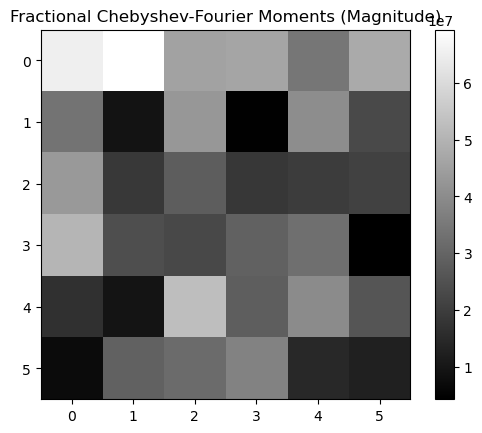

In [39]:
# Load the grayscale image
image_path = "IMG_0612.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define the maximum degree for Chebyshev polynomials and the fractional parameter t
max_degree = 5  # Change depending on desired precision
fractional_parameter_t = 0.5  # Fractional parameter t

# Compute the FrCHFMs
frchfm = compute_frchfm(image, max_degree, fractional_parameter_t)
binary = generate_binary_sequence(frchfm)

# Display results
print("Fractional Chebyshev-Fourier Moments:")
print(frchfm)
print("Binary sequence:")
print(binary, len(binary))

# Visualize the magnitude of the FrCHFMs
plt.imshow(np.abs(frchfm), cmap='gray')
plt.colorbar()
plt.title('Fractional Chebyshev-Fourier Moments (Magnitude)')
plt.show()